# Initial Exploratory Data Analysis

In [2]:
import h5py

In [103]:
# import data
data = h5py.File('./data/train_2.h5')
val = h5py.File('./data/val_2.h5')

In [104]:
data.keys()

[u'all_events']

In [105]:
data['all_events'].keys()

[u'fatJetDEta12',
 u'hist',
 u'histEM',
 u'histtrack',
 u'normalized_weight',
 u'numFatJet',
 u'passSR',
 u'passSR4J',
 u'passSR5J',
 u'sumFatJetM',
 u'weight',
 u'y']

These are the meanings of each branch:
```
[u'hist', # the actual images
 u'histEM', # the images at the em calo level
 u'histtrack', # the number of tracks in the eta-phi range of each cell
 u'normalized_weight', # normalized version of weight, below
 u'numFatJet', # number of fat jets in that event
 u'passSR', # did it pass all cuts?
 u'passSR4J', # did it pass cuts for 4j signal region?
 u'passSR5J', # did it pass cuts for 5j signal region?
 u'sumFatJetM', # summ of mass of all fat jets in that event
 u'weight', # cross section (mostly relevant for getting the JZ background samples to be comparable)
 u'y'] # truth label
```

In [106]:
n_events = 10000
images = data['all_events']['hist'][:n_events]
labels = data['all_events']['y'][:n_events]
weights = data['all_events']['weight'][:n_events]
norm_weights = data['all_events']['normalized_weight'][:n_events]
images_val = val['all_events']['hist'][:n_events]
labels_val = val['all_events']['y'][:n_events]
weights_val = val['all_events']['weight'][:n_events]
norm_weights_val = val['all_events']['normalized_weight'][:n_events]

In [107]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [108]:
matplotlib.rcParams.update({'font.size': 20})

In [109]:
def plot_image(image, vmin=None, vmax=None, weights=None):
    '''
    Args:
    -----
        image: ndarray with energies collected by each calo cell
        vmin: float, min energy to clip at
        vmax: float, max energy to clip at
    '''
    fig = plt.figure(figsize=(10,10))
    im = plt.imshow(image,
               interpolation='nearest',
               norm=LogNorm(vmin, vmax)
    )
    cbar = plt.colorbar(fraction=0.0455)
    cbar.set_label(r'Energy (MeV)', y=0.83)
    cbar.ax.tick_params()   
    plt.ylabel(r'$\eta$ Cell ID')
    plt.xlabel(r'$\phi$ Cell ID')

    plt.tight_layout()
    return im

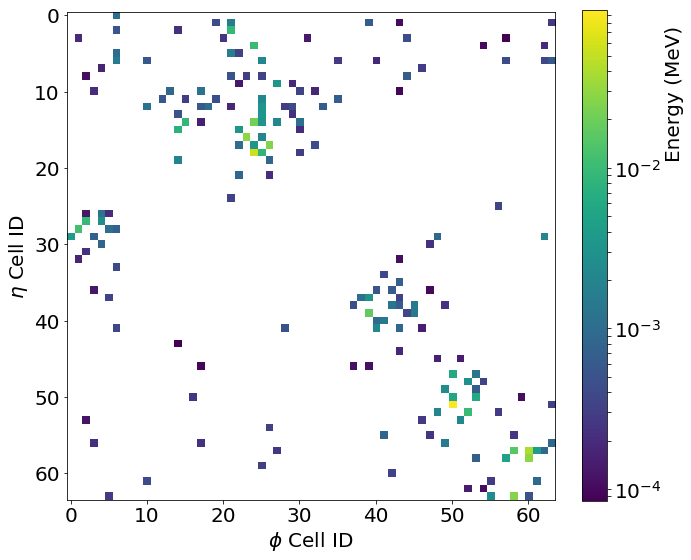

In [110]:
# -- plot the first image
plot_image(images[0])

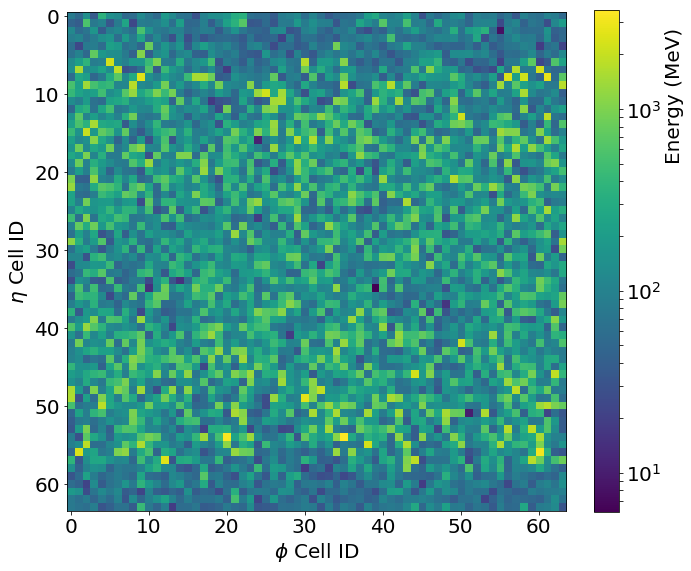

In [111]:
# -- plot the average
plot_image((weights.reshape(-1, 1, 1)*images).mean(axis=0))

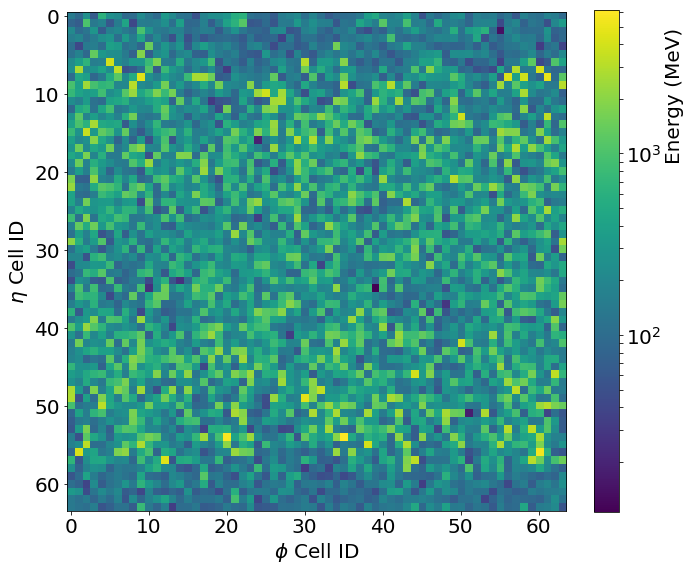

In [113]:
# -- average bkg
plot_image((weights.reshape(-1, 1, 1)*images)[labels==0].mean(axis=0))

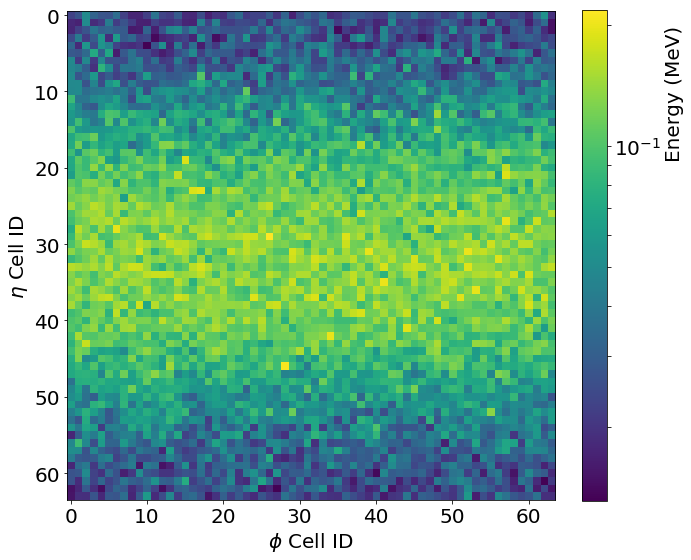

In [114]:
# -- average signal 
plot_image((weights.reshape(-1, 1, 1)*images)[labels==1].mean(axis=0))

In [115]:
import numpy as np

In [116]:
labels.mean() # 43% of events are signal

0.43240000000000001

In [117]:
(weights*labels).sum()/weights.sum() # weighted: very few events are signal

8.7186347199476053e-05

# Evaluate Performance

In [1]:
import numpy as np
import h5py
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve 

In [2]:
f = h5py.File('./data/val_2.h5')
y_true = f['all_events']['y'][:] # y
y_pred = np.load('./prediction_nn_weighted05.npy') #y_hat from micky
w = f['all_events']['weight'][:] # weights

In [3]:
roc_auc_score(y_true, y_pred, sample_weight=w)

0.99836452338161452

In [4]:
confusion_matrix(y_true, y_pred>=0.5, sample_weight=w)

array([[  5.61074467e+11,   4.02104639e+09],
       [  1.09078560e+06,   2.92578682e+07]])

In [5]:
fpr, tpr, _ = roc_curve(y_true, y_pred, sample_weight=w)

Load results from Wahid:

In [6]:
y_wahid = np.load('./val_2_results/pred.npy')

In [7]:
fpr_wahid, tpr_wahid, _ = roc_curve(y_true, y_wahid, sample_weight=w)

Load results from BDT:

In [8]:
y_bdt = np.load('./prediction_nn_weighted01_BDT.npy')

In [9]:
fpr_bdt, tpr_bdt, _ = roc_curve(y_true, y_bdt[:, 1], sample_weight=w)

Load results from 3 channel NN:

In [10]:
y_3ch = np.load('./prediction_nn_weighted01_3ch-CNN.npy')

In [11]:
fpr_3ch, tpr_3ch, _ = roc_curve(y_true, y_3ch, sample_weight=w)

Create simple ensamble by taking the mean of all predictions:

In [17]:
fpr_mean, tpr_mean, _ = roc_curve(y_true, (y_wahid + y_3ch.reshape(-1,))/2,
                                  sample_weight=w)

Compute position of cuts working point:

In [13]:
x_dot = np.sum(w[(f['all_events']['passSR'][:] == 1) & (y_true == 0)]) / np.sum(w[y_true==0])
y_dot = np.sum(w[(f['all_events']['passSR'][:] == 1) & (y_true == 1)]) / np.sum(w[y_true==1])

In [14]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#%matplotlib notebook 
# just to see if I can pickle it, for Wahid

In [15]:
matplotlib.rcParams.update({'font.size': 20})

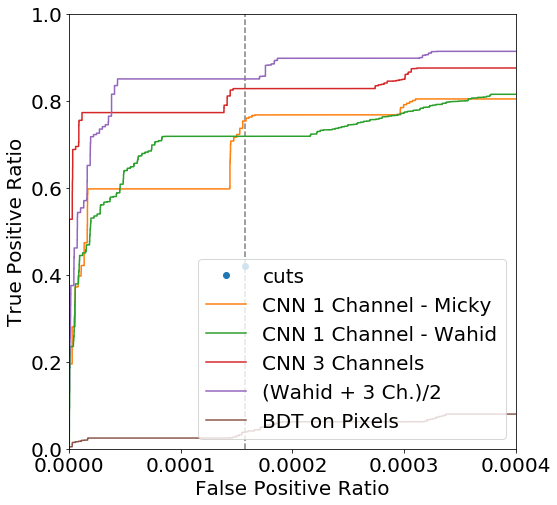

In [22]:
fig = plt.figure(figsize=(8,8))
plt.vlines(x_dot, ymin=0, ymax=1, linestyle='dashed', alpha=0.5, color='black')
plt.plot(x_dot, y_dot, 'o', label='cuts')

_ = plt.plot(fpr, tpr, label='CNN 1 Channel - Micky')
_ = plt.plot(fpr_wahid, tpr_wahid, label='CNN 1 Channel - Wahid')
_ = plt.plot(fpr_3ch, tpr_3ch, label='CNN 3 Channels')
_ = plt.plot(fpr_mean, tpr_mean, label='(Wahid + 3 Ch.)/2')
_ = plt.plot(fpr_bdt, tpr_bdt, label='BDT on Pixels')


plt.xlim(0, 0.0004)
plt.xlabel('False Positive Ratio')
plt.ylabel('True Positive Ratio')
plt.ylim(0, 1)
plt.legend(loc='lower right')

In [29]:
# import pickle
# pickle.dump(fig, open('fig.pickle', 'w'))

In [64]:
# # reopen and plot, just for fun
# import matplotlib.pyplot as plt
# import pickle

# %matplotlib notebook

# fig = pickle.load(open('fig.pickle', 'r'))

## Performance as a function of interesting variables

In [23]:
%matplotlib inline

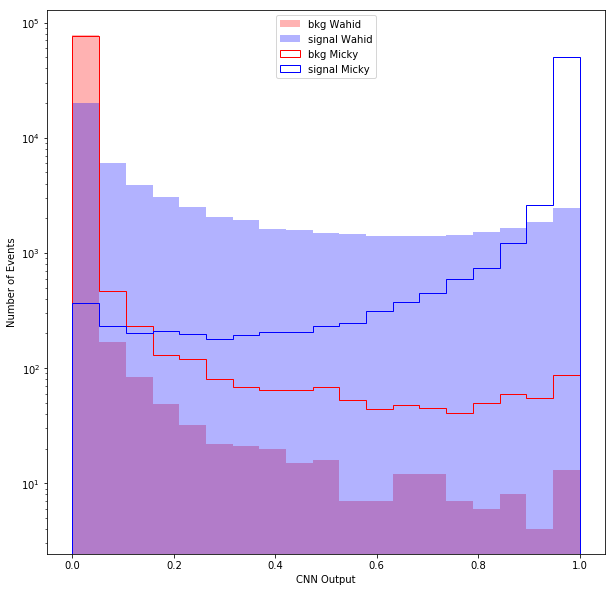

In [24]:
# unweighted output
figure = plt.figure(figsize=(10,10))
bins = np.linspace(0, 1, 20)
_ = plt.hist(y_wahid[y_true == 0], color='red', label='bkg Wahid', histtype='stepfilled',
             alpha=0.3, bins=bins)
_ = plt.hist(y_wahid[y_true == 1], color='blue', label='signal Wahid', histtype='stepfilled',
             alpha=0.3, bins=bins)
_ = plt.hist(y_pred[y_true == 0], color='red', label='bkg Micky', histtype='step', bins=bins)
_ = plt.hist(y_pred[y_true == 1], color='blue', label='signal Micky', histtype='step', bins=bins)

plt.legend(loc='upper center')
plt.yscale('log')
plt.ylabel('Number of Events')
plt.xlabel('CNN Output')

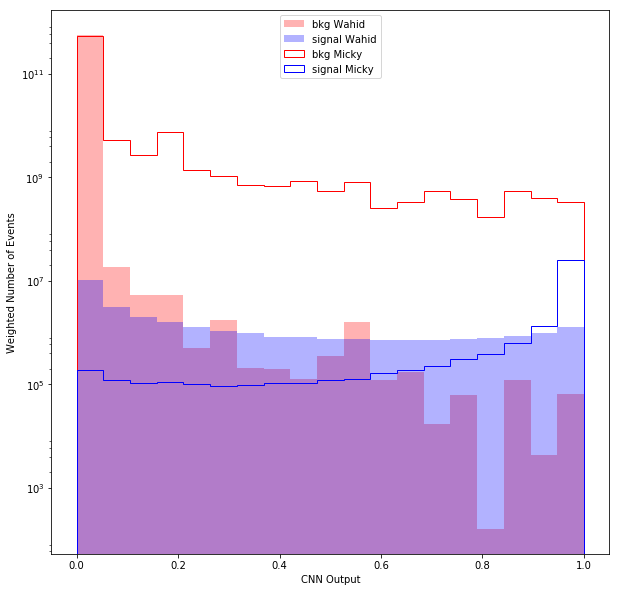

In [25]:
# weighted output
figure = plt.figure(figsize=(10,10))
bins = np.linspace(0, 1, 20)
_ = plt.hist(y_wahid[y_true == 0], color='red', label='bkg Wahid', histtype='stepfilled',
             alpha=0.3, bins=bins, weights=w[y_true == 0])
_ = plt.hist(y_wahid[y_true == 1], color='blue', label='signal Wahid', histtype='stepfilled',
             alpha=0.3, bins=bins, weights=w[y_true == 1])
_ = plt.hist(y_pred[y_true == 0], color='red', label='bkg Micky', histtype='step',
             bins=bins, weights=w[y_true == 0])
_ = plt.hist(y_pred[y_true == 1], color='blue', label='signal Micky', histtype='step',
             bins=bins, weights=w[y_true == 1])

plt.legend(loc='upper center')
plt.yscale('log')
plt.ylabel('Weighted Number of Events')
plt.xlabel('CNN Output')

In [26]:
def plot_output_vs_kin(kin, output, weights, xlabel, ylabel, outname, nbins=30):
    '''
    Plot one output of the discriminator network vs. one of the 1D physics variables that describe jets
    Args:
    -----
        kin : numpy array, kinematic property (such as mass or pT) associated with each image. I.e.: discrete_mass(np.squeeze(generated_images))
        output : numpy array, one of the 2 outputs of the discriminator, evaluated on the same images that `kin` refers to
        xlabel : string, x-axis label that describes the meaning of `kin`
        ylabel : string, y-axis label that describes the meaning og `output`
        outname : name of the output file, to be placed in ../plots/
        nbins : (default = 30) number of bins to use to represent the distributions in a discretized way
    
    '''
    import matplotlib.cm as cm
    from matplotlib.colors import LogNorm, Normalize
    # set the colormap
    plt.set_cmap('jet')
    # draw a 2d histogram of the discriminator's output versus the kinematic variable of choice (mass, pT, etc.)
    h, binx, biny, _ = plt.hist2d(kin, output.reshape(-1,), bins=nbins, weights=weights)
    plt.clf() # we don't want to plot this 2D histogram, we want to normalize it per bin first
    
    # normalize the histogram such that the entries in each column add up to 1, such that the intensity
    # of each corresponds to the percentage of the jets in a given mass (or pT) bin that get assigned a p
    for i in range(nbins):
        h[i, :] = h[i, :] / float(np.sum(h[i, :]))
    # plot the normalized histogram as an image
    f, ax2 = plt.subplots(figsize=(6, 6))
    im = ax2.imshow(
        np.flipud(h.T), 
        interpolation='nearest',
        norm=LogNorm(),
        extent=[binx.min(), binx.max(), biny.min(), biny.max()],
        aspect="auto",
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # add a custom colorbar
    cax = f.add_axes([0.93, 0.1, 0.03, 0.8])
    plt.colorbar(im, cax = cax)
    # save the figure as a pdf
    #plt.savefig(os.path.join('..', outdir, outname), bbox_extra_artists=(cax,), bbox_inches='tight')

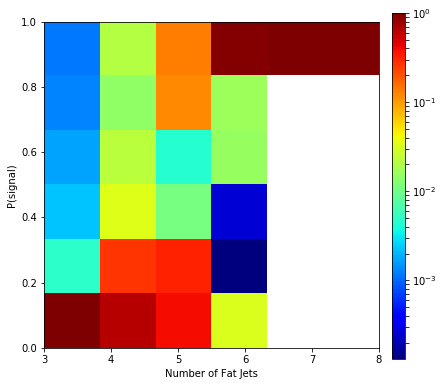

In [27]:
plot_output_vs_kin(
    f['all_events']['numFatJet'][:],
    y_pred,
    weights=w,
    xlabel='Number of Fat Jets',
    ylabel='P(signal)',
    outname='',
    nbins=6
) # micky

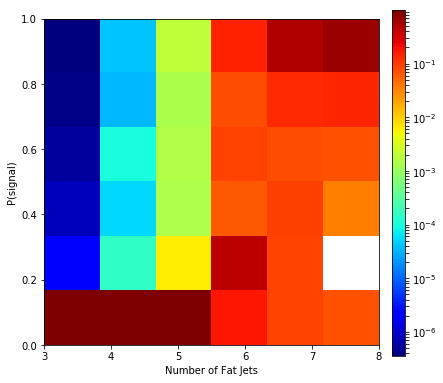

In [28]:
plot_output_vs_kin(
    f['all_events']['numFatJet'][:],
    y_wahid,
    weights=w,
    xlabel='Number of Fat Jets',
    ylabel='P(signal)',
    outname='',
    nbins=6
) # wahid

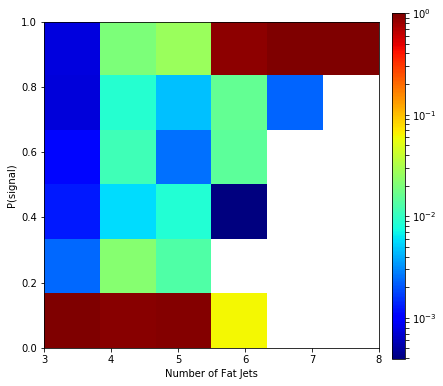

In [29]:
plot_output_vs_kin(
    f['all_events']['numFatJet'][:],
    y_3ch,
    weights=w,
    xlabel='Number of Fat Jets',
    ylabel='P(signal)',
    outname='',
    nbins=6
) # micky

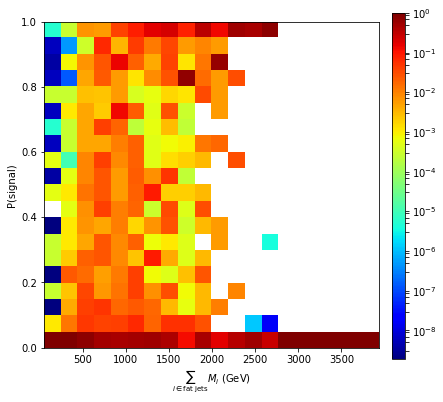

In [30]:
plot_output_vs_kin(
    f['all_events']['sumFatJetM'][:] / 1000,
    y_pred,
    weights=w,
    xlabel=r'$\sum_{i \in \mathrm{fat \ jets}} M_i$ (GeV)',
    ylabel='P(signal)',
    outname='',
    nbins=20
) # micky

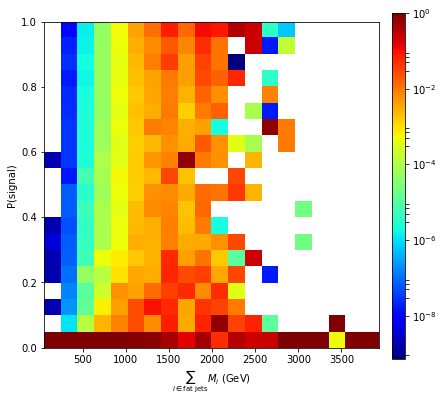

In [31]:
plot_output_vs_kin(
    f['all_events']['sumFatJetM'][:] / 1000,
    y_wahid,
    weights=w,
    xlabel=r'$\sum_{i \in \mathrm{fat \ jets}} M_i$ (GeV)',
    ylabel='P(signal)',
    outname='',
    nbins=20
) # wahid

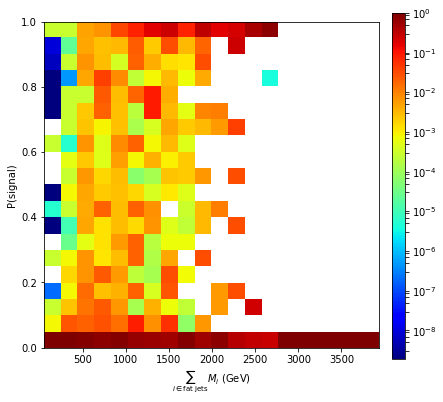

In [32]:
plot_output_vs_kin(
    f['all_events']['sumFatJetM'][:] / 1000,
    y_3ch,
    weights=w,
    xlabel=r'$\sum_{i \in \mathrm{fat \ jets}} M_i$ (GeV)',
    ylabel='P(signal)',
    outname='',
    nbins=20
) # micky

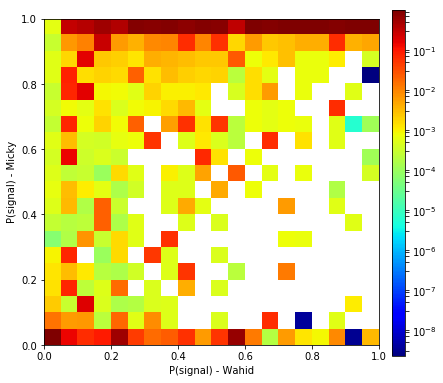

In [33]:
plot_output_vs_kin(
    y_wahid,
    y_3ch,
    weights=w,
    xlabel='P(signal) - Wahid',
    ylabel='P(signal) - Micky',
    outname='',
    nbins=20
) 

In [65]:
from keras.layers import Dense, Input, Dropout
from keras.models import Model

In [66]:
inp = Input(shape=(2,))
h = Dense(64, activation='relu')(inp)
h = Dropout(0.3)(h)
outp = Dense(1, activation='sigmoid')(h)

model = Model(inp, outp)

In [67]:
model.compile('adam', 'binary_crossentropy')

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
model_weights = 'sumM.h5'
try:
    model.load_weights(model_weights)
    print 'Weights loaded from ' + model_weights
except IOError:
    print 'No pre-trained weights found'

try:
    model.fit(
            np.concatenate((
                 y_pred[50000:],
                 (f['all_events']['sumFatJetM'][50000:] / 1000000).reshape(-1,1)
            ), axis=1),
            y_true[50000:],
            sample_weight=w[50000:],
            nb_epoch=50,
            callbacks = [
                EarlyStopping(verbose=True, patience=20, monitor='val_loss'),
                ModelCheckpoint(model_weights,
                    monitor='val_loss', verbose=True, save_best_only=True)
            ],
            validation_data=(
                np.concatenate((
                     y_pred[:50000],
                     (f['all_events']['sumFatJetM'][:50000] / 1000000).reshape(-1,1)
                ), axis=1),
                y_true[:50000],
                w[:50000]),
            verbose=1
    )
    
except KeyboardInterrupt:
    print 'Training finished early'

model.load_weights(model_weights)

Weights loaded from sumM.h5


/Users/mp744/venvs/keras2tf1/lib/python2.7/site-packages/ipykernel/__main__.py:30: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 87471 samples, validate on 50000 samples
Epoch 1/50
87471/87471 [==============================] - 11s - loss: 1208.8847 - val_loss: 936.9342
Epoch 2/50
87471/87471 [==============================] - 11s - loss: 1056.0522 - val_loss: 938.8596
Epoch 3/50
87471/87471 [==============================] - 9s - loss: 1063.3393 - val_loss: 1082.6333
Epoch 4/50
87471/87471 [==============================] - 9s - loss: 894.4011 - val_loss: 1379.7945
Epoch 5/50
87471/87471 [==============================] - 10s - loss: 1011.5999 - val_loss: 1019.5506
Epoch 6/50
87471/87471 [==============================] - 11s - loss: 1099.5876 - val_loss: 939.8357
Epoch 7/50
87471/87471 [==============================] - 9s - loss: 976.5602 - val_loss: 951.7694
Epoch 8/50
87471/87471 [==============================] - 11s - loss: 1159.6352 - val_loss: 929.4529
Epoch 9/50
87471/87471 [==============================] - 11s - loss: 973.8229 - val_loss: 956.5992
Epoch 10/50
87471/87471 [===================

In [69]:
y_hat_sumM = model.predict(
    np.concatenate((
                 y_pred[:50000],
                 (f['all_events']['sumFatJetM'][:50000] / 1000000).reshape(-1,1)
            ), axis=1)
)

In [70]:
fpr_sumM, tpr_sumM, _ = roc_curve(y_true[:50000], y_hat_sumM, sample_weight=w[:50000])

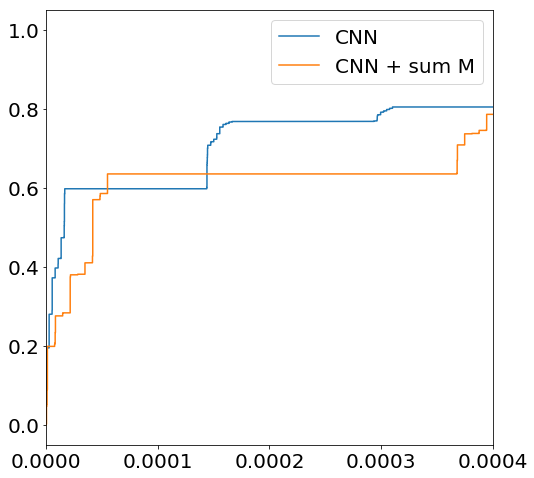

In [71]:
fig = plt.figure(figsize=(8,8))
_ = plt.plot(fpr, tpr, label='CNN')
_ = plt.plot(fpr_sumM, tpr_sumM, label='CNN + sum M')
plt.xlim(0, 0.0004)
plt.legend()